# ARIMA model
ARIMA: Auto-Regressive Intergrated Moving Average. It is a time series forecasting model that takes past data to predict future y series values.

### Mathematical components

**ARIMA consist of 3 parameters ARIMA(p, d, q)**

Auto-Regressive `AR` (p): Linearly regressed on its own past value

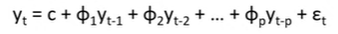

Integrated `I` (q): If not stationary, the time series can be differenced to become stationary 

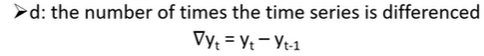

Moving Average `MA` (q): THe time series regressed on past forcast errors

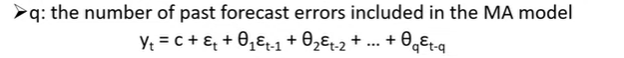

### Examples:
#### Auto-Regression component
Lets say `p = 1`, in this case we would estimate our stock price Y at time t accordingly with only the first order

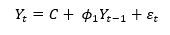

That is only the most recent time lag is of interest to our next period estimation

Increasing the order of p to `p = 2` will result in the following result

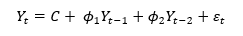

Where more information of stock price at time *t-1 and t-2* affects the stock price by ϕ1 and ϕ2

#### Moving Average component
Lets say `q = 1`, in this case we would estimate our stock price Y at time t accordingly with only the first order

*Note: unlike the auto-regression component, q measures the degree of effect of cumulutive error values at time t to the value of q*

Similarly, increasing the order of p to `q = 3` will result in the following result

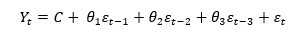

Where more information of stock price at time *t-1, t-2, t-3* affects the stock price by θ_1, θ_2, θ_3

#### "Integrated" component
To utilise our ARMA components, we require the sets of data to be stationary to some degree, later on we will touch on the testing components such as `auto-correlation function` `partial auto-correlation function` and significance testing such as `Augmented Dickey Fuller test (ADF test)`

This process is simply the process of differencing our stock price, for `d=1` we only find the first order differencing

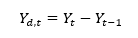

This is the first order differencing

As we increase the order of differencing say `d=2` we will take the former order differencing and apply differencing yet again

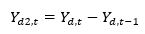

### Objectives and results
#### How it works
The ARIMA model takes lagged values of stock price to regress its future values based on both the error and and price component itself. Many of these formulas follow models of linear regression applied on a rolling basis to continually make predictions of stock prices

#### How to use it
The model requires data sets or derivatives of its data to behave in a `stationary` manner. A stationary data set can be defined in many ways, however in our case we will only focus on the mean of the data set maintaining constant. Volatility measures cannot be measured using ARIMA models but rather i will publish a different model known as `GARCH` that aims to predict future volatility.

Returning to the methods to use the model. We require to back test and retrieve the right parameters that fit the financial asset of interest. A separate timeframe with previously fitted variables `p,d,q` will be used to measure the effectiveness of forecasting

### Retreiving data
Lets query our dataset from SQL and get the relevant stock data we need

In [7]:
import pandas as pd
from sqlalchemy import create_engine, Table, select, MetaData, inspect
from sqlalchemy.orm import sessionmaker, declarative_base
from datetime import date, timedelta

# Reuse Get_data function again to query database
def Get_data(ticker):
    engine = create_engine('sqlite:///Data.db')
    metadata = MetaData()
    metadata.reflect(bind=engine)
    Session = sessionmaker(bind=engine)
    session = Session()

    if ticker in metadata.tables:
        table = Table(ticker, metadata, autoload_with=engine)
        query = select(table).limit(10000)
        result = session.execute(query)
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        session.close()
        return df
    else:
        print(f"Table '{ticker}' not found in the database.")
        session.close()
        return pd.DataFrame()

df = Get_data("GOOG")

### Step 1: Stationarising our data (its not a word...)
Lets see the data, then split our data sets into training and test sets, of course stocks are **DEFINITELY NOT** stationary, so it will determine our degree of stationarising

**The primary goal here is to determine `d` variable**

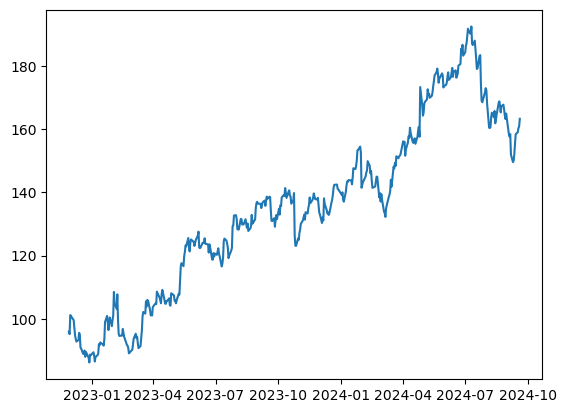

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(df["date"],df["adj_close"])

time to split it apart, lets take the first and 3rd quarter for training and the 2nd and last quarter for testing

In [9]:
df_train1 = df.iloc[0:int(len(df["date"])/4)+1].copy()
df_train2 = df.iloc[2*int(len(df["date"])/4):3*int(len(df["date"])/4)+1].copy()

df_test1 =df.iloc[int(len(df["date"])/4)+1:2*int(len(df["date"])/4)].copy()
df_test2 =df.iloc[3*int(len(df["date"])/4)+1::].copy()

### Is the time series stationary??
Almost definitely **NO**, if it were our model would reduce to the **ARMA** model where time differencing is not necessary

lets find the autocorrelation of the time series with regards to its lags. That is, for every Y.t-1 -> Y.t , is the correlation coefficient strong enough to predict future values of Y.t+1 with regards to additional errors.

Without additional information between Y.t and Y.t-k how do we find the auto-correlation without Y.t-1, Y.t-2 .... Y.t-k+1

Other than our own visual perception of the actual data itself here are some useful plots that reduce subejectiviti

### Stationarity plots: (partial)Auto-correlative functions

`plot_acf` provides the time lagged correlation in time series values

`plot_pacf` provides time lagged partial auto correlation in gapped time series values

### What is Partial auto correlation function and Auto correlation function
#### Partial Auto Correlation Function
PACF or `Partial Auto correlation function` is a widely used function that gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags.

For example, assuming we have the follwing sets of price data at time t

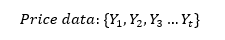

The PACF finds the values of their partial correlation across various timelags accounting for shorter time lags

The price at time t in the PACF is modelled by the following at order q

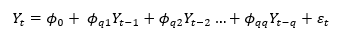

Where the value of PACF at time q is ϕ_qq

#### Implications of the partial auto currelation function
The PACF can provide us indication of the value q, or rather the order ogf variable q for our arima model, where by values most highyl predicting the next day prices are predicted by the values at time q

#### Auto Correlation Function
ACF or `Auto correlation function` aims solely to find the correlation of the time series to its lags. It does so by offsetting the time series by `x` at every instance and finding correlation of the the dataset to the offset. 

For example, assuming we have the price data set from time 1 to t

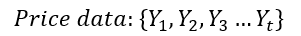

The AutoCorrelation functions aims to find the correlation based on the following series.

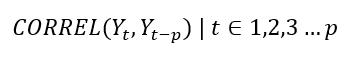

Clearly, the autocorrelation function only serves to provide the information of lag variables **Ignoring** lower order time lags

#### Implications of Auto Correlation function
Firstly, a auto correlation function that doesnt drop off quickly is displaying what is known as `persistence` whereby persistence is the tendency for the variables to display certain directional trends across the time series. For example plotting our stock price time series gives us this graph

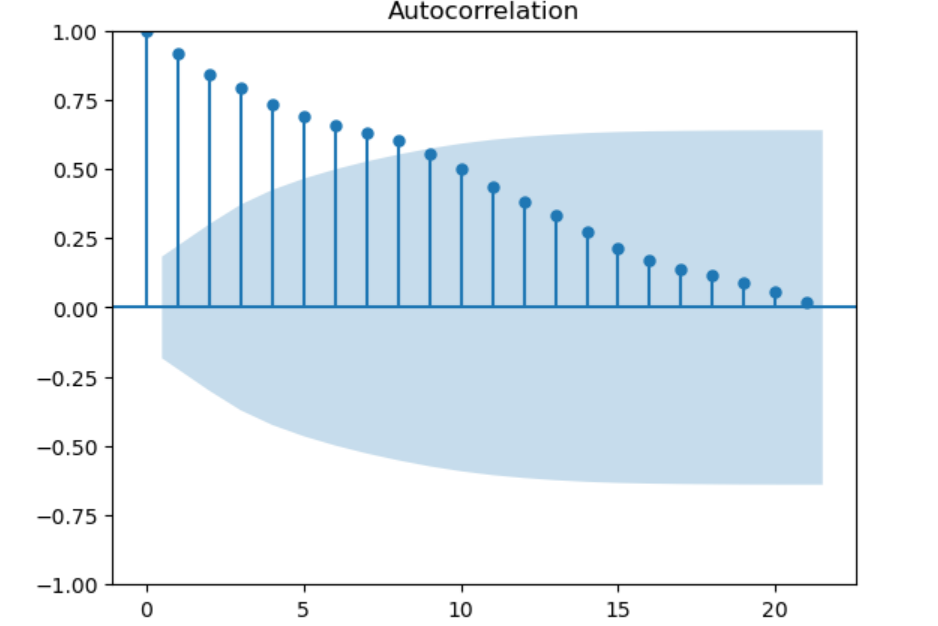

The strong persisting positive autocorrelation is a hallmark sign of `STRONG UPWARD TRENDING SERIES`

This meamns thaty the data is not stationary, and differencing is required to reduce upward trends

Fortunately, there are inbuilt stats models to help us plot ACF and PACF

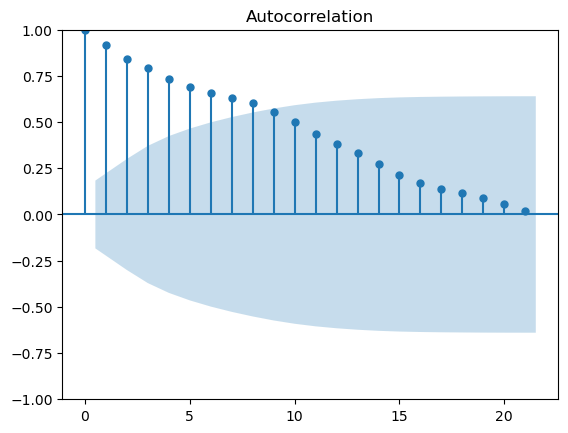

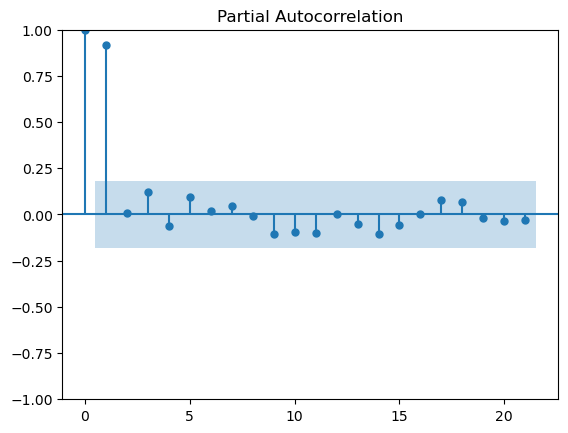

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_train1 = plot_acf(df_train1["adj_close"])
pcf_train1 = plot_pacf(df_train1["adj_close"])

#### Stationarity of plots: Augmented Dickey Fuller test
The most quantitative and absolute manner of determining the stationarity is utiling the Augmented Dickey Fuller tests that will return us the p-value, For which tests agains the null-hypothesis that the time series is stationary at a 95% confidence interval

The most appropriate function to use here is the adf_test function provided in the statsmodels packages

In [ ]:
from statsmodels.graphics.stattools import adfull



### Step 2 Differencing
As we see here